# Spaceship Titanic Kaggle Competition Attempt 1


## Basic Wrangling

In [1]:
# the usual imports
import pandas as pd
import numpy as np
import xgboost as xg

# sklearn stuff
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_curve, f1_score, auc, accuracy_score, log_loss, classification_report,confusion_matrix,roc_curve,roc_auc_score

# will be doing some optimization I'm sure
import hyperopt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [3]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


It looks at a casual glance like we have more variables than in the Titanic challenge.  Also, more of them are quantitative.  Interesting.

In [4]:
quant_list = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

In [5]:
train_data.shape

(8693, 14)

In [6]:
# how many NaN's by column?
total = 0
for column in train_data.columns:
    print("variable:", column, "NaN count:", train_data[column].isna().sum())
    total += train_data[column].isna().sum()
print("total NaN's:", total)

variable: PassengerId NaN count: 0
variable: HomePlanet NaN count: 201
variable: CryoSleep NaN count: 217
variable: Cabin NaN count: 199
variable: Destination NaN count: 182
variable: Age NaN count: 179
variable: VIP NaN count: 203
variable: RoomService NaN count: 181
variable: FoodCourt NaN count: 183
variable: ShoppingMall NaN count: 208
variable: Spa NaN count: 183
variable: VRDeck NaN count: 188
variable: Name NaN count: 200
variable: Transported NaN count: 0
total NaN's: 2324


This is problematic.  We have 8693 observations, and 2324 total NaN's.  Probably, there are some rows with multiple NaN's, but at any rate, this is simply too many to discard. __Particularly__ considering this is a Kaggle competition.  It seems obvious to me that this challenge is very much about imputation of missing values.  Of course there are a variety of ways to go about this, I'm going to try to approach it systematically.


In [7]:
# what about the test set?
total = 0
for column in test_data.columns:
    print("variable:", column, "NaN count:", test_data[column].isna().sum())
    total += test_data[column].isna().sum()
print("total NaN's:", total)

variable: PassengerId NaN count: 0
variable: HomePlanet NaN count: 87
variable: CryoSleep NaN count: 93
variable: Cabin NaN count: 100
variable: Destination NaN count: 92
variable: Age NaN count: 91
variable: VIP NaN count: 93
variable: RoomService NaN count: 82
variable: FoodCourt NaN count: 106
variable: ShoppingMall NaN count: 98
variable: Spa NaN count: 101
variable: VRDeck NaN count: 80
variable: Name NaN count: 94
total NaN's: 1117


So the missing values will be a problem, too, for the test set.  Simply ignoring all records with NaN's isn't even a possible (though bad) solution.

In [8]:
# it may be relevant whether people are travelling in parties
# multiple people with same last name might be a reasonable proxy for this

train_data[["FirstName", "LastName"]]=train_data["Name"].str.split(" ", expand=True)


In [9]:
train_data[train_data["Name"].isnull()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,FirstName,LastName
27,0022_01,Mars,False,D/0/P,TRAPPIST-1e,21.0,False,980.0,2.0,69.0,0.0,0.0,NaN,False,NaN,NaN
58,0064_01,Mars,True,F/14/S,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,0.0,0.0,NaN,True,NaN,NaN
65,0069_01,Earth,False,F/16/S,TRAPPIST-1e,42.0,False,887.0,0.0,9.0,6.0,0.0,NaN,True,NaN,NaN
77,0082_03,Mars,False,F/16/P,TRAPPIST-1e,8.0,False,0.0,0.0,0.0,0.0,0.0,NaN,True,NaN,NaN
101,0108_02,Earth,False,G/19/S,TRAPPIST-1e,31.0,False,562.0,0.0,326.0,0.0,0.0,NaN,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8629,9205_02,Europa,True,B/300/P,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,0.0,0.0,NaN,True,NaN,NaN
8631,9208_01,Earth,True,G/1485/S,TRAPPIST-1e,35.0,False,0.0,0.0,0.0,0.0,0.0,NaN,True,NaN,NaN
8636,9218_01,Europa,True,B/353/S,55 Cancri e,43.0,False,0.0,0.0,0.0,0.0,0.0,NaN,True,NaN,NaN
8652,9230_01,Europa,False,C/342/S,TRAPPIST-1e,36.0,True,0.0,5600.0,715.0,2868.0,971.0,NaN,True,NaN,NaN


Just wanted to make sure that the null values propagated across that split, instead of something... weird.

In [10]:
train_data.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,FirstName,LastName
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,Maham,Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,Juanna,Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,Altark,Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,Solam,Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,Willy,Santantines
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True,Sandie,Hinetthews
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True,Billex,Jacostaffey
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True,Candra,Jacostaffey
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True,Andona,Beston
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True,Erraiam,Flatic


In [11]:
train_data["LastName"].value_counts()["Susent"]

6

In [12]:
# train_data["LastNameCount"] = train_data["LastName"].value_counts()[train_data["LastName"]]
# produces KeyError: '[nan] not in index'

train_data["LastNameCount"] = train_data.groupby("LastName")["LastName"].transform('count')


In [13]:
train_data.head(20)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,FirstName,LastName,LastNameCount
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,Maham,Ofracculy,1.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,Juanna,Vines,4.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,Altark,Susent,6.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,Solam,Susent,6.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,Willy,Santantines,6.0
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True,Sandie,Hinetthews,7.0
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True,Billex,Jacostaffey,7.0
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True,Candra,Jacostaffey,7.0
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True,Andona,Beston,5.0
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True,Erraiam,Flatic,3.0


We also have some useful data in the deceptively informative 'Cabin' field.  From the Kaggle competition page:

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
    
This should be broken up into three columns...


In [14]:
train_data[["Deck", "Num", "Side"]]=train_data["Cabin"].str.split("/", expand=True)

In [15]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,FirstName,LastName,LastNameCount,Deck,Num,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,Maham,Ofracculy,1.0,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,Juanna,Vines,4.0,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,Altark,Susent,6.0,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,Solam,Susent,6.0,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,Willy,Santantines,6.0,F,1,S


In [16]:
# turns out that 'PassengerId' consists of a group number and a passenger number...
train_data[["Group", "Passenger"]]=train_data["PassengerId"].str.split("_", expand=True)
train_data["GroupCount"]=train_data.groupby("Group")["Group"].transform('count')
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Transported,FirstName,LastName,LastNameCount,Deck,Num,Side,Group,Passenger,GroupCount
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,False,Maham,Ofracculy,1.0,B,0,P,0001,01,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,True,Juanna,Vines,4.0,F,0,S,0002,01,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,False,Altark,Susent,6.0,A,0,S,0003,01,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,False,Solam,Susent,6.0,A,0,S,0003,02,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,True,Willy,Santantines,6.0,F,1,S,0004,01,1


Of course, I'm going to need to expand the test data as well.

In [17]:
test_data[["Deck", "Num", "Side"]]=test_data["Cabin"].str.split("/", expand=True)
test_data[["FirstName", "LastName"]]=test_data["Name"].str.split(" ", expand=True)
test_data["LastNameCount"] = test_data.groupby("LastName")["LastName"].transform('count')
test_data[["Group", "Passenger"]]=test_data["PassengerId"].str.split("_", expand=True)
test_data["GroupCount"]=test_data.groupby("Group")["Group"].transform('count')

It occurs to me that the "LastNameCount" should arguably be aggregated across both the test and training sets; I'll come back to consider this.

In [18]:
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Deck,Num,Side,FirstName,LastName,LastNameCount,Group,Passenger,GroupCount
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,...,Nelly Carsoning,G,3,S,Nelly,Carsoning,4.0,0013,01,1
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,...,Lerome Peckers,F,4,S,Lerome,Peckers,1.0,0018,01,1
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,...,Sabih Unhearfus,C,0,S,Sabih,Unhearfus,1.0,0019,01,1
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,...,Meratz Caltilter,C,1,S,Meratz,Caltilter,1.0,0021,01,1
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,...,Brence Harperez,F,5,S,Brence,Harperez,3.0,0023,01,1


It also occurs to me that all of the actual information in the "Cabin" and "Name" columns now exists in other columns.  This will cause fitting problems with several methods, and of course is just redundant.  If the original variables are ever needed, they can easily be reconstructed.  Let's drop them.

In [19]:
train_data.drop(["Cabin", "Name"], axis=1, inplace=True)
test_data.drop(["Cabin", "Name"], axis=1, inplace=True)


In [20]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Transported,FirstName,LastName,LastNameCount,Deck,Num,Side,Group,Passenger,GroupCount
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,False,Maham,Ofracculy,1.0,B,0,P,0001,01,1
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,True,Juanna,Vines,4.0,F,0,S,0002,01,1
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,...,False,Altark,Susent,6.0,A,0,S,0003,01,2
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,...,False,Solam,Susent,6.0,A,0,S,0003,02,2
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,...,True,Willy,Santantines,6.0,F,1,S,0004,01,1


Ok, looks like I'm ready to proceed to some basic EDA, which will inform imputation (I suspect this will be important here) and model selection. 

# EDA

In [21]:
# these may very well be needed here
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
# let's start with value counts...
vc_list = ["HomePlanet", "CryoSleep", "Destination", "VIP", "LastNameCount", "GroupCount", "Deck", "Side"]
for col in vc_list:
    print("variable:", col)
    print(train_data[col].value_counts())

variable: HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64
variable: CryoSleep
False    5439
True     3037
Name: CryoSleep, dtype: int64
variable: Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64
variable: VIP
False    8291
True      199
Name: VIP, dtype: int64
variable: LastNameCount
4.0     1280
5.0     1280
3.0     1164
6.0     1038
7.0      833
2.0      800
8.0      544
1.0      382
9.0      315
10.0     300
11.0     275
12.0      84
13.0      78
14.0      56
15.0      30
18.0      18
16.0      16
Name: LastNameCount, dtype: int64
variable: GroupCount
1    4805
2    1682
3    1020
4     412
5     265
7     231
6     174
8     104
Name: GroupCount, dtype: int64
variable: Deck
F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: Deck, dtype: int64
variable: Side
S    4288
P    4206
Name: Side, dtype: int64


In [48]:
# let's compare value counts across the outcome variable, "Transported":
for col in vc_list:
    print("variable:", col)
    print(train_data.groupby("Transported")[col].value_counts())

variable: HomePlanet
Transported  HomePlanet
False        Earth         2651
             Mars           839
             Europa         727
True         Earth         1951
             Europa        1404
             Mars           920
Name: HomePlanet, dtype: int64
variable: CryoSleep
Transported  CryoSleep
False        False        3650
             True          554
True         True         2483
             False        1789
Name: CryoSleep, dtype: int64
variable: Destination
Transported  Destination  
False        TRAPPIST-1e      3128
             55 Cancri e       702
             PSO J318.5-22     395
True         TRAPPIST-1e      2787
             55 Cancri e      1098
             PSO J318.5-22     401
Name: Destination, dtype: int64
variable: VIP
Transported  VIP  
False        False    4093
             True      123
True         False    4198
             True       76
Name: VIP, dtype: int64
variable: LastNameCount
Transported  LastNameCount
False        4.0            

In [49]:
# perhaps it will be more informative to reverse the order of the groupby and value counts:
for col in vc_list:
    print(train_data.groupby(col)["Transported"].value_counts())

HomePlanet  Transported
Earth       False          2651
            True           1951
Europa      True           1404
            False           727
Mars        True            920
            False           839
Name: Transported, dtype: int64
CryoSleep  Transported
False      False          3650
           True           1789
True       True           2483
           False           554
Name: Transported, dtype: int64
Destination    Transported
55 Cancri e    True           1098
               False           702
PSO J318.5-22  True            401
               False           395
TRAPPIST-1e    False          3128
               True           2787
Name: Transported, dtype: int64
VIP    Transported
False  True           4198
       False          4093
True   False           123
       True             76
Name: Transported, dtype: int64
LastNameCount  Transported
1.0            True           223
               False          159
2.0            False          405
               T

In [50]:
# this could be lengthy, but...
pd.set_option("display.max_rows", None)
train_data.groupby("LastName")["Transported"].value_counts()

LastName     Transported
Acobson      False           3
             True            1
Acobsond     False           2
             True            1
Adavisons    False           5
             True            4
Adkinson     False           3
Admingried   True            3
             False           1
Ageurante    True            1
Aginge       True            1
Ailled       False           1
             True            1
Aillyber     True            2
             False           1
Aiming       True            1
Ainatint     True            3
Aindlylid    False           2
Ainserfle    True            7
             False           4
Airdring     False           1
Aivering     False           1
             True            1
Alaring      True            5
             False           2
Alaxed       False           1
             True            1
Alberts      False           4
             True            2
Alcemblery   False           5
Alenat       False           2
             T

In [51]:
train_data.groupby("FirstName")["Transported"].value_counts()

FirstName  Transported
Aard       False           1
Aarjel     False           2
Aark       False           1
           True            1
Aarone     False           4
           True            4
Aars       True            1
Acceleb    True            2
Achah      False           1
           True            1
Achbah     False           2
           True            1
Achib      True            4
Achira     False           3
           True            1
Achiram    True            3
Achium     False           2
           True            2
Achyon     True            2
           False           1
Acraban    False           1
Acrabih    True            2
Acrabik    True            2
Acruxon    True            5
Adamie     True            3
           False           1
Adammy     False           2
           True            1
Adamy      False           3
           True            1
Adanne     True            3
           False           2
Adharan    True            2
Adria      True     

I was hoping to see a lot more names that were only true or only false.  That's not to say there isn't an association with names, there could very well be.  I should consider what kind of metric might be applicable here.

However, some of these variables can be visualized usefully.


In [52]:
train_data.groupby("HomePlanet")["Transported"].value_counts()

HomePlanet  Transported
Earth       False          2651
            True           1951
Europa      True           1404
            False           727
Mars        True            920
            False           839
Name: Transported, dtype: int64

In [53]:
vc = train_data.groupby("HomePlanet")["Transported"].value_counts()

In [54]:
vc

HomePlanet  Transported
Earth       False          2651
            True           1951
Europa      True           1404
            False           727
Mars        True            920
            False           839
Name: Transported, dtype: int64

In [55]:
type(vc)

pandas.core.series.Series

In [56]:
vc[0]

2651

In [57]:
vc.index

MultiIndex([( 'Earth', False),
            ( 'Earth',  True),
            ('Europa',  True),
            ('Europa', False),
            (  'Mars',  True),
            (  'Mars', False)],
           names=['HomePlanet', 'Transported'])

In [58]:
vc.index[1][0]

'Earth'

In [59]:
len(vc.index)

6

In [60]:
len(vc.iloc[::2].index)

3

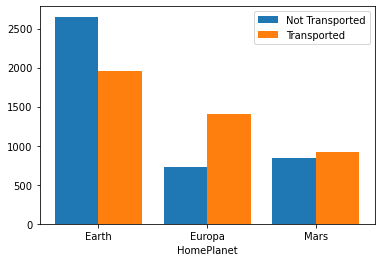

In [61]:
X_axis = np.arange(len(vc.index)/2)
plt.bar(X_axis - 0.2, vc[vc.index.get_level_values('Transported') == False], 0.4, label="Not Transported")
plt.bar(X_axis + 0.2, vc[vc.index.get_level_values('Transported') == True], 0.4, label="Transported")
plt.xticks(X_axis, ['Earth', 'Europa', 'Mars'])
plt.xlabel("HomePlanet")
plt.legend()
plt.show()

That worked nicely, and on the first try - can I generalize it?  Side by side bar graphs should serve well for the categorical variables here.

C:\Users\steph\AppData\Local\Temp/ipykernel_5544/2566987311.py:6: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
  X_axis_list.append(vc.iloc[::2].index[i][0])


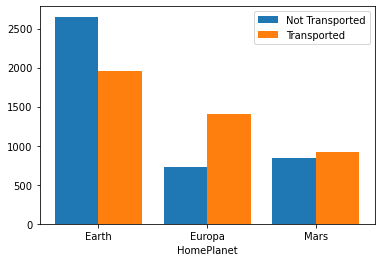

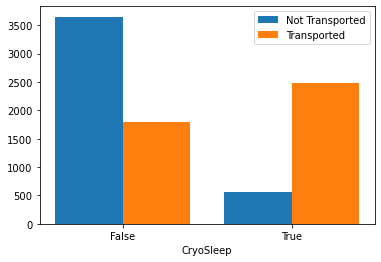

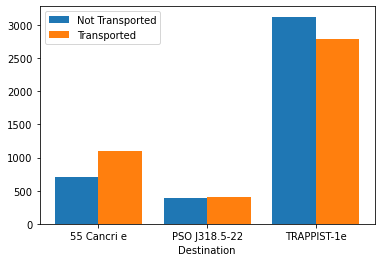

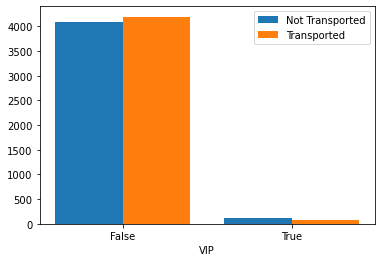

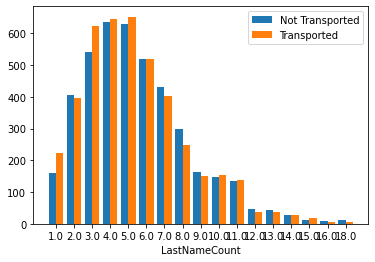

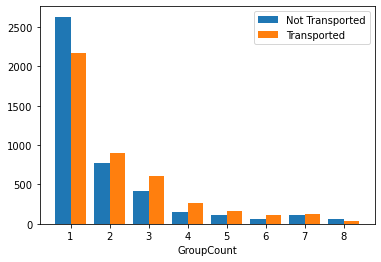

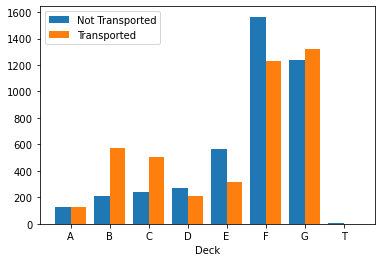

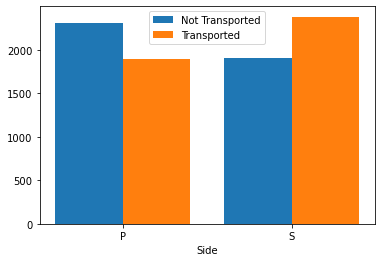

In [62]:
for col in vc_list:
    vc = train_data.groupby(col)["Transported"].value_counts()
    X_axis = np.arange(len(vc.index)/2)
    X_axis_list = []
    for i in np.arange(len(vc.index)/2):
        X_axis_list.append(vc.iloc[::2].index[i][0])
    plt.bar(X_axis - 0.2, vc[vc.index.get_level_values('Transported') == False], 0.4, label="Not Transported")
    plt.bar(X_axis + 0.2, vc[vc.index.get_level_values('Transported') == True], 0.4, label="Transported")
    plt.xticks(X_axis, X_axis_list)
    plt.xlabel(col)
    plt.legend()
    plt.show()

Great!  It would have been tedious to do all of those manually.  There are some interesting points to note in passing:  HomePlanet seems to have a substantial effect, at least with respect to Earth v Europa.  Obviously, CryoSleep makes Transported far more likely, too.  Destination appears to have something of a weaker effect....


I'm curious, though, about the LastNameCount variable - is there significant evidence that these counts are not from the same distribution?  It's been a while since I've run a formal hypothesis test.

In [38]:
lnc_t = train_data[train_data["Transported"] == True].LastNameCount.value_counts().sort_index()
lnc_f = train_data[train_data["Transported"] == False].LastNameCount.value_counts().sort_index()

In [39]:
lnc_t

1.0     223
2.0     395
3.0     622
4.0     645
5.0     652
6.0     518
7.0     401
8.0     247
9.0     152
10.0    153
11.0    139
12.0     36
13.0     36
14.0     27
15.0     18
16.0      6
18.0      7
Name: LastNameCount, dtype: int64

In [40]:
type(lnc_f)

pandas.core.series.Series

In [41]:
lnc_chi_sq = pd.concat([lnc_t, lnc_f], axis=1)
lnc_chi_sq.columns = (['Transported', 'Not Transported'])

In [42]:
lnc_chi_sq

,Transported,Not Transported
1.0,223,159
2.0,395,405
3.0,622,542
4.0,645,635
5.0,652,628
6.0,518,520
7.0,401,432
8.0,247,297
9.0,152,163
10.0,153,147


In [43]:
import scipy
r = scipy.stats.chisquare(lnc_chi_sq)

In [44]:
dir(r)


['__add__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_asdict',
 '_field_defaults',
 '_fields',
 '_make',
 '_replace',
 'count',
 'index',
 'pvalue',
 'statistic']

In [45]:
r.statistic

array([3646.52232874, 3436.66129032])

Somewhat surprisingly, these test statistics are indeed so large as to give a p-value of, effectively, zero... I suppose that when considering the number of observations this should have been obvious.  At any rate, it's reasonable to expect this variable to have some predictive power.

It might also be informative to do a little similar basic EDA for the quantitative variables.

In [63]:
quant_list

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [71]:
tt = train_data['Age'][train_data['Transported'] == True]

In [72]:
tt


1       24.0
4       16.0
5       44.0
6       26.0
7       28.0
8       35.0
9       14.0
10      34.0
11      45.0
12      32.0
14      28.0
18      45.0
19       0.0
24      10.0
28      62.0
33      47.0
34       2.0
35      20.0
36      28.0
41      17.0
44       4.0
45      21.0
47      19.0
51      25.0
52       2.0
53      38.0
54      27.0
58      15.0
59      33.0
61       0.0
62      18.0
65      42.0
70      42.0
71      27.0
72      28.0
76       2.0
77       8.0
78      24.0
79      40.0
81      45.0
82      35.0
83      26.0
86       0.0
87       3.0
90      26.0
92       2.0
93      31.0
95      24.0
96       9.0
102      0.0
105     42.0
106     28.0
107     29.0
108     48.0
109     64.0
111     26.0
112     33.0
114     13.0
115     24.0
118     67.0
122     22.0
123     19.0
125     19.0
127     13.0
129     35.0
130     24.0
133     20.0
135     50.0
137      NaN
141     26.0
142     17.0
143     57.0
145     35.0
146     13.0
150     19.0
151     32.0
152     58.0

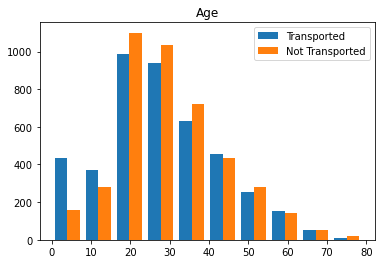

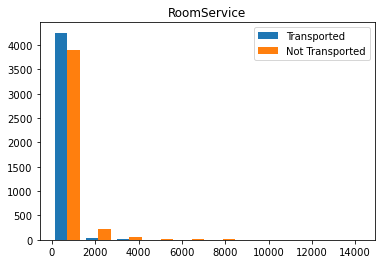

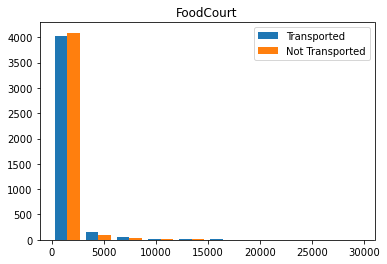

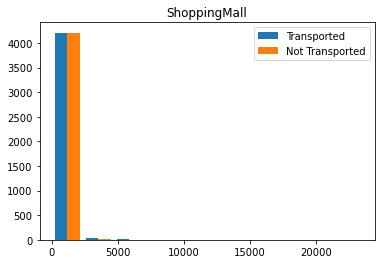

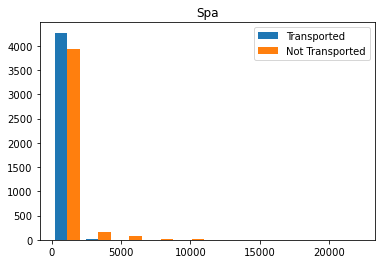

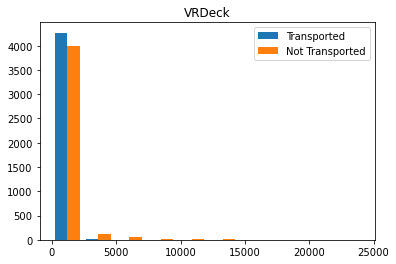

In [75]:
for col in quant_list:
    tt = train_data[col][train_data["Transported"] == True]
    nt = train_data[col][train_data["Transported"] == False]
    plt.hist([tt, nt], label=["Transported", "Not Transported"])
    plt.title(col)
    plt.legend()
    plt.show()

These histograms are simply _atrocious_ - but I'm not terribly interested in perfecting them.  We can see some variation with respect to age.  The amount spent on various amenities generally seems to increase the chances of transportation.

# Imputation of Missing Values

As discussed above, all potentially relevant predictors have a nontrivial proportion of missing values - too many to discard.  Imputation is clearly an important component of this competition, and I'd like to approach it in an appropriate manner.

It might also be interesting to compare results from different categories of imputation methods.  A complication, of course, is that the same method must be applied to the test set.

# Modeling

In [ ]:
# it will be useful to store results
results_cols = ['model type', 'imputation', 'hyperparameters', 'f1', 'roc_auc', 'accuracy']
# it's my understanding that submissions will be judged on accuracy
results = pd.DataFrame(columns = results_cols)
